# Autoencoders that don't overfit towards the Identity

This notebook provides an implementation in Python 3.7.7 (and Tensorflow 1.15.0) of the algorithms outlined in the paper 
"Autoencoders that don't overfit towards the Identity" 
at the 34th Conference on Neural Information Processing Systems (NeurIPS 2020).

For reproducibility, the experiments utilize publicly available [code](https://github.com/dawenl/vae_cf) for pre-processing three popular data-sets and for evaluating the learned models. That code accompanies the paper "[Variational autoencoders for collaborative filtering](https://arxiv.org/abs/1802.05814)" by Dawen Liang et al. at The Web Conference 2018. While the code for the Movielens-20M data-set was made publicly available, the code for pre-processing the other two data-sets can easily be obtained by modifying their code as described in their paper.
The experiments were run on an AWS instance with 128 GB RAM and 16 vCPUs.

In [1]:
import os
import shutil
import sys
import time
from copy import deepcopy

import numpy as np
from scipy import sparse
import pandas as pd
import bottleneck as bn
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.contrib.layers import apply_regularization, l2_regularizer


In [2]:
# change to the location of the data
DATA_DIR = '/my/data/directory/'

itemId='songId'   # for MSD data

In [3]:
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'train_triplets.txt'), sep='\t', header=None, names=['userId', 'songId', 'playCount'])

## Pre-processing of the Data 

Utilizing the publicly available [code](https://github.com/dawenl/vae_cf), which is copied below (with kind permission of Dawen Liang). Note that the following code is modified as to pre-process the [MSD data-set](https://labrosa.ee.columbia.edu/millionsong/tasteprofile). For pre-processing the [MovieLens-20M data-set](https://grouplens.org/datasets/movielens/20m/), see their original publicly-available [code](https://github.com/dawenl/vae_cf).

### Data splitting procedure
- Select 50K users as heldout users, 50K users as validation users, and the rest of the users for training
- Use all the items from the training users as item set
- For each of both validation and test user, subsample 80% as fold-in data and the rest for prediction 

In [4]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

In [5]:
def filter_triplets(tp, min_uc=5, min_sc=0):
    # Only keep the triplets for items which were clicked on by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, itemId)
        tp = tp[tp[itemId].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, itemId) 
    return tp, usercount, itemcount

In [6]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data, min_uc=20, min_sc=200) # for MSD data

In [7]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 33633450 watching events from 571355 users and 41140 movies (sparsity: 0.143%)


In [8]:
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

In [9]:
# create train/validation/test users
n_users = unique_uid.size
n_heldout_users = 50000 # for MSD data

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

In [10]:
train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]

In [11]:
unique_sid = pd.unique(train_plays[itemId])

In [12]:
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [13]:
pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [14]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 5000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [15]:
vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays[itemId].isin(unique_sid)]

In [16]:
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

0 users sampled
5000 users sampled
10000 users sampled
15000 users sampled
20000 users sampled
25000 users sampled
30000 users sampled
35000 users sampled
40000 users sampled
45000 users sampled


In [17]:
test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
test_plays = test_plays.loc[test_plays[itemId].isin(unique_sid)]

In [18]:
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

0 users sampled
5000 users sampled
10000 users sampled
15000 users sampled
20000 users sampled
25000 users sampled
30000 users sampled
35000 users sampled
40000 users sampled
45000 users sampled


### Save the data into (user_index, item_index) format

In [19]:
def numerize(tp):
    uid = map(lambda x: profile2id[x], tp['userId'])
    sid = map(lambda x: show2id[x], tp[itemId])
    return pd.DataFrame(data={'uid': list(uid), 'sid': list(sid)}, columns=['uid', 'sid'])

In [20]:
train_data = numerize(train_plays)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)

In [21]:
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

In [22]:
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

In [23]:
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

In [24]:
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

## Load the pre-processed training and test data

In [25]:
unique_sid = list()
with open(os.path.join(pro_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)

In [26]:
def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data

In [27]:
# load training data
train_data = load_train_data(os.path.join(pro_dir, 'train.csv'))

In [28]:
#Pre-computation of the item-item training-data (used by analytic solutions)
XtX= np.asarray(train_data.T.dot(train_data).todense(), dtype = np.float32)  
XtXdiag = deepcopy(np.diag(XtX))   
ii_diag = np.diag_indices(XtX.shape[0])

In [29]:
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

In [30]:
test_data_tr, test_data_te = load_tr_te_data(
    os.path.join(pro_dir, 'test_tr.csv'),
    os.path.join(pro_dir, 'test_te.csv'))

## Model Evaluation 

Utilizing the publicly available [code](https://github.com/dawenl/vae_cf), which is copied below (with kind permission of Dawen Liang).


In [31]:
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG

In [32]:
def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

In [33]:
def evaluate(BB, test_data_tr = test_data_tr, test_data_te = test_data_te):
    print("evaluating ...")
    N_test = test_data_tr.shape[0]
    idxlist_test = range(N_test)

    batch_size_test = 5000
    n100_list, r20_list, r50_list = [], [], []
    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_data_tr[idxlist_test[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        pred_val = X.dot(BB)
        # exclude examples from training and validation (if any)
        pred_val[X.nonzero()] = -np.inf
        n100_list.append(NDCG_binary_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=100))
        r20_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=50))

    n100_list = np.concatenate(n100_list)
    r20_list = np.concatenate(r20_list)
    r50_list = np.concatenate(r50_list)
    print("Test NDCG@100=%.5f (%.5f)" % (np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
    print("Test Recall@20=%.5f (%.5f)" % (np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
    print("Test Recall@50=%.5f (%.5f)" % (np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))

In [34]:
class MyClock:
    startTime = time.time()
    def tic(self):
        self.startTime = time.time()
    def toc(self):
        secs = time.time() - self.startTime 
        print("... elapsed time: {} min {} sec".format(int(secs//60), secs%60) )

myClock = MyClock()

## Methods for Learning the various models in Table 1 in the paper 

In [35]:
def learn_EDLAE_fullrank(pdrop, L2const, XtX = XtX, XtXdiag = XtXdiag, iidiag = ii_diag):
    # full-rank EDLAE, implements Eqs. 8 and 9 in the Paper
    XtX[ii_diag]= XtXdiag + L2const + XtXdiag * pdrop / (1.0-pdrop) 
    BB=np.linalg.inv(XtX)
    BB/=-np.diag(BB)
    BB[ii_diag]=0.0
    return BB

In [36]:
def learn_EDLAE_analytic(pdrop, L2const, omega, hidden_dim, train_epochs, init_scale = 0.0001, XtX = XtX, XtXdiag = XtXdiag, iidiag = ii_diag):
    # low-rank EDLAE, implements ADMM approach derived in the Supplement to the Paper     
    #precompute
    OmegaDiag = L2const + XtXdiag * pdrop / (1.0-pdrop)  +omega # penalty-vector in ADMM
    XtX[ii_diag]= XtXdiag  + L2const + XtXdiag * pdrop / (1.0-pdrop)
    PP=np.linalg.inv(XtX)   
    #intitialization
    betaVec= np.zeros(XtX.shape[0])
    gammaVec= np.zeros(XtX.shape[0])
    UU=np.random.randn(XtX.shape[0],hidden_dim) * init_scale
    # ADMM iterations     
    for itercnt in range(train_epochs):
        print(" iteration step: {}".format(itercnt))
        #### update VVt
        XtX[ii_diag]= XtXdiag  + L2const + XtXdiag * pdrop / (1.0-pdrop) + OmegaDiag
        HH=UU.T.dot(XtX).dot(UU)
        HH= np.linalg.inv(HH)  .dot(UU.T)
        XtX[ii_diag]= XtXdiag
        GG= XtX *(1.0+betaVec)
        GG[ii_diag]+= OmegaDiag*  (betaVec-gammaVec)
        VVt= HH.dot(GG)
        #update UU
        HH= VVt.dot(VVt.T)
        HH=np.linalg.inv(HH)
        HH=VVt.T.dot(HH)
        XtX[ii_diag]= XtXdiag
        UU= XtX *(1.0+betaVec)
        UU[ii_diag]+= OmegaDiag *  (betaVec-gammaVec)
        UU= UU.dot(HH)
        UU=PP.dot(UU)
        # update betaVec
        UUVVt = UU.dot(VVt)
        UUVVdiag  = np.diag(UUVVt)
        XtX[ii_diag]= XtXdiag
        HH = np.diag(XtX.dot(UUVVt)) - XtXdiag + OmegaDiag*(UUVVdiag+gammaVec)
        GG = XtXdiag + OmegaDiag - XtXdiag * pdrop / (1.0-pdrop) - L2const 
        betaVec = HH / GG
        betaVec=np.maximum(betaVec, 0.0) # self-similarity has be non-negative (for stability)
        # update gammaVec
        gammaVec+= UUVVdiag-betaVec   
    return [UU,VVt.T]

In [37]:
#low-rank with (0-diagonal or not)-constraint, with prdouct-L2, 
# for lines 2 nd 3 without constraint
# for figure 1, with and without constraint
# if 0-diag approximation to EDLAE for large matrix-ranks
def learn_EDLAE_approx(zeroDiagConstraint, pdrop, L2const, hidden_dim, train_epochs, init_scale = 0.0001, XtX = XtX, XtXdiag = XtXdiag, iidiag = ii_diag):
    # approximates low-rank EDLAE for: 
    # 1. small matrix rank (-> unconstrained diagonal), and 
    # 2. large marrix rank (-> zero-diagonal enforced)
    if zeroDiagConstraint:
        print("zero diagonal enforced during training ...")
    else:
        print("unconstrained diagonal during training ...")
    #precompute
    XtX[ii_diag]= XtXdiag  + L2const + XtXdiag * pdrop / (1.0-pdrop)
    CC=np.linalg.inv(XtX)
    #random initialization
    VVt=np.random.randn(hidden_dim, XtX.shape[0]) * init_scale
    # iterative optimization
    for itercnt in range(train_epochs):
        print(" iteration step: {}".format(itercnt))
        #update UU
        GG= VVt.dot(VVt.T)
        GG=np.linalg.inv(GG)
        # note: gammaVec equals eta + diag(Lambda) in the Supplement
        gammaVec= L2const + XtXdiag * pdrop / (1.0-pdrop) # without zero-diag constraint            
        if zeroDiagConstraint:
            KK = VVt.T.dot(GG).dot(VVt)
            gammaVec= np.linalg.solve( CC * KK   , np.diag(KK))
        HH=CC *(-gammaVec) 
        HH[ii_diag]+=1.0
        UU=HH.dot( VVt.T.dot(GG) )
        #update VV
        XtX[ii_diag]= XtXdiag  + L2const + XtXdiag * pdrop / (1.0-pdrop)
        HH=UU.T.dot(XtX).dot(UU)
        HH= np.linalg.inv(HH)  .dot(UU.T)
        XtX[ii_diag]= XtXdiag
        VVt= HH.dot(XtX )
        if zeroDiagConstraint:
            diag_up = np.diag(UU.dot(VVt))
            diag_down = np.diag(UU.dot(HH))
            etaVec= diag_up / diag_down 
            VVt-= HH * etaVec        
    return [UU,VVt.T]

In [38]:
def learn_DAE_stochastic(pdrop, L2constAdd, L2constProd, hidden_dim, train_epochs, bsize =4096, X = train_data ):
    # sampled denoising autoencoder, implemented using tensorflow     
    features_dim=X.shape[1]
    tf.reset_default_graph()  # reset graph if run many times
    # training data
    training_data = tf.placeholder(tf.float32, shape=(None, features_dim), name='training_data')
    # L2-regularization lambda
    lamAdd = tf.placeholder(tf.float32, shape=(), name='lambdaAdd')
    lamProd = tf.placeholder(tf.float32, shape=(), name='lambdaProd')
    # weight matrices
    UU = tf.get_variable(name="UU", shape=[features_dim, hidden_dim], initializer=tf.contrib.layers.xavier_initializer())
    VVt = tf.get_variable(name="VVt", shape=[hidden_dim, features_dim], initializer=tf.contrib.layers.xavier_initializer())
    WeightMatrices=[UU,VVt]
    # network architecture
    h_in = tf.nn.dropout(training_data, rate= pdrop) # stochastic denoising applied to input
    h_hidden = tf.matmul(h_in, UU)   # linear model
    h_out =   tf.matmul(h_hidden, VVt)
    # L2 regularization as in Line 1 in Table 1 in the paper
    regAdd = l2_regularizer(lamAdd)        
    L2regAdd = apply_regularization(regAdd, WeightMatrices)
    regProd = l2_regularizer(lamProd)        
    L2regProd = apply_regularization(regProd, [ tf.matmul(UU,VVt) ])  
    # squared error + stochastic denoising + L2 regularization
    mse = tf.reduce_mean( tf.square(tf.subtract(training_data, h_out)))
    loss = mse + L2regAdd + L2regProd
    # optimizer
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss)
    # training
    N = X.shape[0]
    idxlist = np.arange(N)
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        loss_list = list()
        mse_list = list()
        for epoch in range(train_epochs):
            loss_epoch = list()
            mse_epoch = list()
            np.random.shuffle(idxlist)
            for bnum, st_idx in enumerate(range(0, N, bsize)):
                end_idx = min(st_idx + bsize, N)
                inp = X[idxlist[st_idx:end_idx]]
                if sparse.isspmatrix(inp):
                    trainBatch = inp.toarray().astype('float32')          
                feed_dict = {training_data:trainBatch, lamAdd:L2constAdd, lamProd:L2constProd}
                l, m, _ = sess.run([loss, mse, train_op], feed_dict=feed_dict)
                loss_epoch.append(l)
                mse_epoch.append(m)
            loss_list.append(np.mean(loss_epoch))
            mse_list.append(np.mean(mse_epoch))
            print("Epoch: %d, training_rmse=%.3f, training_loss=%.3f" % (epoch, np.sqrt(mse_list[-1]), loss_list[-1]))
        UUfinal = sess.run(UU)
        VVfinal = sess.run(VVt).T 
    return [UUfinal,VVfinal]

## Training of the various models in Table 1

In [39]:
# line 1 in Table 1 in the Paper

#L2constAdd, train_epochs = [ 8e-6, 5 ] # for ML-20M data
#L2constAdd, train_epochs = [ 8e-6, 5 ] # for Netflix data
L2constAdd, train_epochs = [ 2e-7, 5 ] # for MSD data

pdrop = 0.0 
L2constProd = 0.0
hidden_dim =1000
myClock.tic()
UU,VV=learn_DAE_stochastic(pdrop, L2constAdd, L2constProd, hidden_dim, train_epochs)
myClock.toc()
evaluate(UU.dot(VV.T))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Epoch: 0, training_rmse=0.037, training_loss=0.002
Epoch: 1, training_rmse=0.034, training_loss=0.001
Epoch: 2, training_rmse=0.032, training_loss=0.001
Epoch: 3, training_rmse=0.032, training_loss=0.001
Epoch: 4, training_rmse=0.032, training_loss=0.001
... elapsed time: 250 min 5.366348743438721 sec
evaluating ...
Test NDCG@100=0.24844 (0.00093)
Test Recall@20=0.19967 (0.00093)
Test Recall@50=0.27749 (0.00106)


In [40]:
# line 2 in Table 1 in the Paper
# and also used for the blue dotted line in Figure 1 (left)

#L2const, train_epochs = [ 10000.0, 5 ] # for ML-20M data
#L2const, train_epochs = [ 100000.0, 5 ] # for Netflix data
L2const, train_epochs = [ 30000.0, 5 ] # for MSD data


zeroDiagConstraint = False
pdrop = 0.0
hidden_dim =1000
myClock.tic()
UU_freediag,VV_freediag = learn_EDLAE_approx(zeroDiagConstraint, pdrop, L2const, hidden_dim, train_epochs)
myClock.toc()
evaluate(UU_freediag.dot(VV_freediag.T))

unconstrained diagonal during training ...
 iteration step: 0
 iteration step: 1
 iteration step: 2
 iteration step: 3
 iteration step: 4
... elapsed time: 17 min 29.487412214279175 sec
evaluating ...
Test NDCG@100=0.26636 (0.00095)
Test Recall@20=0.21677 (0.00095)
Test Recall@50=0.29608 (0.00106)


In [41]:
# line 3 in Table 1 in the Paper

#pdrop, L2const, train_epochs = [ 0.67, 200.0, 5 ] # for ML-20M data
#pdrop, L2const, train_epochs = [ 0.67, 500.0, 5 ] # for Netflix data
pdrop, L2const, train_epochs = [ 0.75, 20.0, 5 ] # for MSD data


zeroDiagConstraint = False
hidden_dim =1000
myClock.tic()
UU,VV = learn_EDLAE_approx(zeroDiagConstraint, pdrop, L2const, hidden_dim, train_epochs)
myClock.toc()
evaluate(UU.dot(VV.T))

unconstrained diagonal during training ...
 iteration step: 0
 iteration step: 1
 iteration step: 2
 iteration step: 3
 iteration step: 4
... elapsed time: 17 min 26.759504556655884 sec
evaluating ...
Test NDCG@100=0.31475 (0.00101)
Test Recall@20=0.25980 (0.00102)
Test Recall@50=0.35086 (0.00111)


In [42]:
# line 4 in Table 1 in the Paper

#pdrop, L2constProd, train_epochs = [ 0.67, 3e-9, 10 ]   # for ML-20M data
#pdrop, L2constProd, train_epochs = [ 0.67, 2e-9, 10 ]   # for Netflix data
pdrop, L2constProd, train_epochs = [ 0.67, 1e-14, 10 ]   # for MSD data


L2constAdd = 0.0
hidden_dim =1000
myClock.tic()
UU,VV=learn_DAE_stochastic(pdrop, L2constAdd, L2constProd, hidden_dim, train_epochs)
myClock.toc()
evaluate(UU.dot(VV.T))

Epoch: 0, training_rmse=0.039, training_loss=0.001
Epoch: 1, training_rmse=0.036, training_loss=0.001
Epoch: 2, training_rmse=0.035, training_loss=0.001
Epoch: 3, training_rmse=0.034, training_loss=0.001
Epoch: 4, training_rmse=0.034, training_loss=0.001
Epoch: 5, training_rmse=0.034, training_loss=0.001
Epoch: 6, training_rmse=0.034, training_loss=0.001
Epoch: 7, training_rmse=0.034, training_loss=0.001
Epoch: 8, training_rmse=0.034, training_loss=0.001
Epoch: 9, training_rmse=0.034, training_loss=0.001
... elapsed time: 507 min 10.029773712158203 sec
evaluating ...
Test NDCG@100=0.30890 (0.00100)
Test Recall@20=0.25551 (0.00102)
Test Recall@50=0.34343 (0.00111)


In [43]:
# line 5 in Table 1 in the Paper

#pdrop, L2const, omega, train_epochs = [ 0.33, 400.0, 500.0, 5 ]   # for ML-20M data
#pdrop, L2const, omega, train_epochs = [ 0.15, 500.0, 500.0, 10 ]   # for Netflix data
pdrop, L2const, omega, train_epochs = [ 0.1, 10.0, 500.0, 20 ]   # for MSD data

hidden_dim =1000
myClock.tic()
UU,VV = learn_EDLAE_analytic(pdrop, L2const, omega, hidden_dim, train_epochs)
myClock.toc()
evaluate(UU.dot(VV.T))

 iteration step: 0
 iteration step: 1
 iteration step: 2
 iteration step: 3
 iteration step: 4
 iteration step: 5
 iteration step: 6
 iteration step: 7
 iteration step: 8
 iteration step: 9
 iteration step: 10
 iteration step: 11
 iteration step: 12
 iteration step: 13
 iteration step: 14
 iteration step: 15
 iteration step: 16
 iteration step: 17
 iteration step: 18
 iteration step: 19
... elapsed time: 215 min 18.817319869995117 sec
evaluating ...
Test NDCG@100=0.31943 (0.00102)
Test Recall@20=0.26369 (0.00104)
Test Recall@50=0.35462 (0.00112)


In [44]:
# used for green solid line in Figure 1 (left)

#L2const, train_epochs = [ 500.0, 10 ]  # for ML-20M data
#L2const, train_epochs = [ 1000.0, 10 ]  # for Netflix data
L2const, train_epochs = [ 200.0, 10 ]  # for MSD data
 
zeroDiagConstraint = True
pdrop = 0.0
hidden_dim =1000
myClock.tic()
UU_0diag,VV_0diag = learn_EDLAE_approx(zeroDiagConstraint, pdrop, L2const, hidden_dim, train_epochs)
myClock.toc()
evaluate(UU_0diag.dot(VV_0diag.T))

zero diagonal enforced during training ...
 iteration step: 0
 iteration step: 1
 iteration step: 2
 iteration step: 3
 iteration step: 4
 iteration step: 5
 iteration step: 6
 iteration step: 7
 iteration step: 8
 iteration step: 9
... elapsed time: 63 min 40.53152918815613 sec
evaluating ...
Test NDCG@100=0.30179 (0.00100)
Test Recall@20=0.24939 (0.00101)
Test Recall@50=0.33314 (0.00110)


## Cosine-Similarity Plots, like in Figure 1 

In [45]:
# compute full-rank EDLAE to determine the most similar items for each item
# given that it is the most accurate model in this notebook

#pdrop, L2const =  [ 0.33 , 300.0 ]    # for ML-20M data
#pdrop, L2const =  [ 0.33 , 500.0 ]    # for Netflix data
pdrop, L2const =  [ 0.25 , 70.0 ]    # for MSD data

BB_fullrank = learn_EDLAE_fullrank(pdrop, L2const)
evaluate(BB_fullrank)

topSims =10
BB_fullrank[ii_diag] =1.0  #include item itself into set of similar items
ixSims = bn.argpartition(-BB_fullrank, topSims, axis=0)[:topSims,:] # top similar items in each column

evaluating ...
Test NDCG@100=0.39151 (0.00110)
Test Recall@20=0.33408 (0.00114)
Test Recall@50=0.42948 (0.00119)


In [46]:
def calc_cosineSimilarity(EE, ixSims):
    EEn= EE / np.sqrt(np.sum(EE*EE,1))[:,None]
    EEcosine = EEn.dot(EEn.T)
    cosineSimilarity = np.ones(ixSims.shape[1])
    for ii in range(ixSims.shape[1]):
        ii_sims = ixSims[:,ii]
        simMat=EEcosine[np.ix_(ii_sims,ii_sims)]
        cosineSimilarity[ii] = np.median(simMat[np.triu_indices(topSims, k=1)]) # median of all pairs i <> j
    return cosineSimilarity

Text(0, 0.5, 'density')

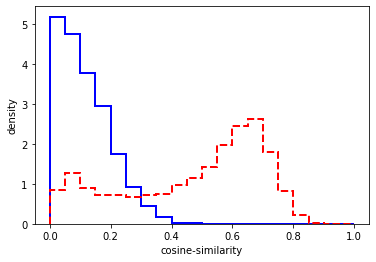

In [47]:
# The diagonal is constrained to zero, i.e, (near-)orthogonality constraint.
# This is an approximation to fully emphasized denoising.
# As an (indirect) consequence, the learned embeddings of similar items are NOT similar, 
# i.e., their cosine-similarities are close to 0, especially in the learned encoder-matrix UU.

UU_0diag_cosine = calc_cosineSimilarity(UU_0diag, ixSims) # embeddings UU_0diag, VV_0diag computed above
VV_0diag_cosine = calc_cosineSimilarity(VV_0diag, ixSims)

plt.hist(UU_0diag_cosine, bins=20, range=(0.0,1.0), density=True,histtype='step', color='blue', linewidth=2.0, linestyle='-')
plt.hist(VV_0diag_cosine, bins=20, range=(0.0,1.0), density=True,histtype='step', color='red', linewidth=2.0, linestyle='--')
plt.xlabel('cosine-similarity')
plt.ylabel('density')

Text(0, 0.5, 'density')

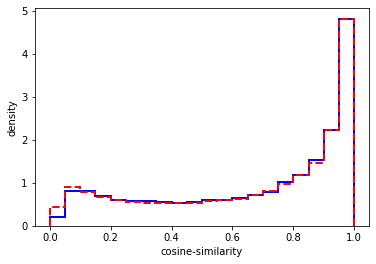

In [48]:
# Unconstrained diagonal, i.e., only L2 norm regularization, like in denoising autoencoder. 
# As a consequence, similar items have similar embeddings, as indicated by cosine-similarities close to 1.

UU_freediag_cosine = calc_cosineSimilarity(UU_freediag, ixSims) # embeddings UU_freediag, VV_freediag computed above
VV_freediag_cosine = calc_cosineSimilarity(VV_freediag, ixSims)

plt.hist(UU_freediag_cosine, bins=20, range=(0.0,1.0), density=True,histtype='step', color='blue', linewidth=2.0, linestyle='-')
plt.hist(VV_freediag_cosine, bins=20, range=(0.0,1.0), density=True,histtype='step', color='red', linewidth=2.0, linestyle='--')
plt.xlabel('cosine-similarity')
plt.ylabel('density')
